In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from enum import Enum
from tqdm import tqdm
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

import lime
import lime.lime_text
import lime.lime_tabular

import torch
from folktables import ACSDataSource, ACSIncome

# local libraries
import exp_utils as eu

In [3]:
# dataset selection
class Data(Enum):
    REVIEWS = 1
    INCOME = 2


Data = Enum("Data", ["REVIEWS", "INCOME"])

## Section 0: Load Data

In [4]:
# set dataset
# dataset = Data.REVIEWS
DS = Data.REVIEWS

In [5]:
if DS == Data.REVIEWS:
    train_df = pd.read_csv("data/reviews_train.csv")
    test_df = pd.read_csv("data/reviews_test.csv")

    tf_vec = TfidfVectorizer(lowercase=False, stop_words="english")
    X_train_vec = tf_vec.fit_transform(train_df["text"].values)  # .toarray()
    X_test_vec = tf_vec.transform(test_df["text"].values)  # .toarray()
    X_train = train_df["text"].values
    X_test = test_df["text"].values
    y_train = train_df["label"]
    y_test = test_df["label"]

elif DS == Data.INCOME:
    state = "HI"
    year = "2018"
    data_source = ACSDataSource(survey_year=year, horizon="1-Year", survey="person")
    acs_data = data_source.get_data(states=[state], download=True)
    features, label, group = ACSIncome.df_to_numpy(acs_data)
    X_train, X_test, y_train, y_test = train_test_split(
        features, label, test_size=0.20, random_state=42
    )
    scale = StandardScaler()
    X_train_vec = scale.fit_transform(X_train)
    X_test_vec = scale.transform(X_test)


t_xtrain = torch.tensor(X_train_vec.toarray(), dtype=torch.float32)
t_ytrain = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
t_xtest = torch.tensor(X_test_vec.toarray(), dtype=torch.float32)
t_ytest = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

xtrain, xval, ytrain, yval = train_test_split(
    t_xtrain, t_ytrain, test_size=0.20, random_state=42
)

In [6]:
# compare performance across different model classes
model_lin_svm = SVC(
    kernel="linear",
    probability=True,
)
model_lin_svm.fit(X_train_vec, y_train)
print(f"linear SVM: {model_lin_svm.score(X_test_vec, y_test)}")

linear SVM: 0.878125


## Section 1: Regularization

In [ ]:
results_list = []
num_seeds = 5
seed_results = np.zeros((num_seeds, len(t_ytest)))
if DS == Data.REVIEWS:
    const_arr = [0, 0.1, 0.25, 0.5]
    batch_arr = [10, 25, 50]
elif DS == Data.INCOME:
    const_arr = [0.1, 0.25, 0.75]
    batch_arr = [10, 25, 50]

for c in const_arr:
    for batch_size in batch_arr:
        for i in range(num_seeds):
            print(f"Running c={c} bsize={batch_size}, run={i}")
            torch.manual_seed(i)
            xtrain, xval, ytrain, yval = train_test_split(
                t_xtrain, t_ytrain, test_size=0.20, random_state=i
            )

            ref_pred = model_lin_svm.predict(xtrain)
            dataset = eu.ExpDataset(
                xtrain,
                ytrain,
                ref_pred=torch.tensor(ref_pred, dtype=torch.float32).reshape(-1, 1),
            )
            model = eu.Wide(input_size=t_xtrain.shape[1])
            acc = eu.model_train_reg(
                model,
                dataset,
                xval,
                yval,
                ref_model=model_lin_svm.predict,
                batch_size=batch_size,
                c=c,
            )

            yhat1 = model_lin_svm.predict(X_train_vec)
            yhat2 = model(t_xtrain).round().detach().numpy().flatten()
            disagreement = np.where(yhat1 != yhat2)[0]
            dis_ratio_train = len(disagreement) / len(yhat1)
            train_acc = (yhat2 == y_train).sum() / len(y_train)
            print(train_acc, dis_ratio_train)

            yhat1 = model_lin_svm.predict(X_test_vec)
            yhat2 = model(t_xtest).round().detach().numpy().flatten()
            disagreement = np.where(yhat1 != yhat2)[0]
            dis_ratio_test = len(disagreement) / len(yhat1)
            test_acc = (yhat2 == y_test).sum() / len(y_test)
            print(test_acc, dis_ratio_test)

            incorr1 = yhat1 != y_test
            incorr2 = yhat2 != y_test
            common_err = np.logical_and(incorr1, incorr2)
            corrected = incorr1.sum() - common_err.sum()
            seed_results[i] = yhat2

            results_list.append(
                {
                    "run": i,
                    "const": c,
                    "batch_size": batch_size,
                    "acc": test_acc,
                    "corrected": corrected,
                    "train_dis": dis_ratio_train,
                    "test_dis": dis_ratio_test,
                }
            )
            results_df = pd.DataFrame(results_list)
            dataset_str = str(DS).split(".")[1]
            results_df.to_csv(f"results/{dataset_str}_reg2.csv")

In [55]:
np.save("results/reg_overlap.npy", seed_results)

## Section 2: Reweighting

In [ ]:
results_list = []
num_seeds = 5
seed_results = np.zeros((num_seeds, len(t_ytest)))
if DS == Data.REVIEWS:
    const_arr = [0, 1.0, 10.0, 50]
    batch_arr = [50, 100, 150, 200]
elif DS == Data.INCOME:
    const_arr = [0, 0.5, 1.0, 5.0]
    batch_arr = [20, 50, 100, 200]


for c in const_arr:
    for batch_size in batch_arr:  # , 100, 150, 200]:
        for i in range(num_seeds):
            print(f"Running c={c} bsize={batch_size}, run={i}")
            xtrain, xval, ytrain, yval = train_test_split(
                t_xtrain, t_ytrain, test_size=0.20, random_state=i
            )
            weight_vector = torch.tensor(
                model_lin_svm.predict(xtrain.detach().numpy()).reshape(-1, 1)
                != ytrain.detach().numpy(),
                dtype=torch.float32,
            )

            dataset = eu.ExpDataset(xtrain, ytrain, weights=weight_vector)
            model = eu.Wide(input_size=t_xtrain.shape[1])
            acc = eu.model_train_weight(
                model,
                dataset,
                xval,
                yval,
                ref_model=model_lin_svm.predict,
                batch_size=batch_size,
                c=c,
            )
            print("Accuracy (wide): %.2f" % acc)

            yhat1 = model_lin_svm.predict(X_train_vec)
            yhat2 = model(t_xtrain).round().detach().numpy().flatten()
            disagreement = np.where(yhat1 != yhat2)[0]
            dis_ratio_train = len(disagreement) / len(yhat1)
            train_acc = (yhat2 == y_train).sum() / len(y_train)

            print(train_acc, dis_ratio_train)

            yhat1 = model_lin_svm.predict(X_test_vec)
            yhat2 = model(t_xtest).round().detach().numpy().flatten()
            disagreement = np.where(yhat1 != yhat2)[0]
            dis_ratio_test = len(disagreement) / len(yhat1)
            test_acc = (yhat2 == y_test).sum() / len(y_test)
            print(test_acc, dis_ratio_test)

            # save seed results
            seed_results[i] = yhat2

            incorr1 = yhat1 != y_test
            incorr2 = yhat2 != y_test
            common_err = np.logical_and(incorr1, incorr2)
            corrected = incorr1.sum() - common_err.sum()

            results_list.append(
                {
                    "run": i,
                    "const": c,
                    "batch_size": batch_size,
                    "acc": test_acc,
                    "corrected": corrected,
                    "train_dis": dis_ratio_train,
                    "test_dis": dis_ratio_test,
                }
            )

            results_df = pd.DataFrame(results_list)
            dataset_str = str(DS).split(".")[1]
            results_df.to_csv(f"results/{dataset_str}reweighing_replication.csv")
            # np.save("results/reweight_overlap.npy", seed_results)

In [127]:
# total overlap 
((seed_results.T != np.repeat(y_test.reshape(-1, 1), 5, axis=1)).sum(axis=1) > 1).sum()

1080

In [24]:
def predict_proba_text(X_docs):
    X_vect = torch.tensor(tf_vec.transform(X_docs).todense(), dtype=torch.float32)
    preds = model(X_vect).detach().numpy()
    prob = np.concatenate((1 - preds, preds), axis=1)
    return prob


def predict_proba_tab(X_docs):
    X_vect = torch.tensor(scale.transform(X_docs), dtype=torch.float32)
    preds = model(X_vect).detach().numpy()
    prob = np.concatenate((1 - preds, preds), axis=1)
    return prob

### Reg Explanations

In [43]:
results_list = []
model_exp_list = []

if DS == Data.REVIEWS:
    const_arr = [0, 0.1, 0.25, 0.5]
    batch_arr = [10]
    n_feat = 10
elif DS == Data.INCOME:
    const_arr = [0.1, 0.25, 0.5, 0.75]
    batch_arr = [10]
    n_feat = 5
i = 0
for c in const_arr:
    for batch_size in batch_arr:
        print(f"Running c={c} bsize={batch_size}, run={i}")
        torch.manual_seed(i)
        xtrain, xval, ytrain, yval = train_test_split(
            t_xtrain, t_ytrain, test_size=0.20, random_state=i
        )

        ref_pred = model_lin_svm.predict(xtrain)
        dataset = eu.ExpDataset(
            xtrain,
            ytrain,
            ref_pred=torch.tensor(ref_pred, dtype=torch.float32).reshape(-1, 1),
        )
        model = eu.Wide(input_size=t_xtrain.shape[1])
        acc = eu.model_train_reg(
            model,
            dataset,
            xval,
            yval,
            ref_model=model_lin_svm.predict,
            batch_size=batch_size,
            c=c,
        )
        print("Accuracy (wide): %.2f" % acc)

        yhat1 = model_lin_svm.predict(X_train_vec)
        yhat2 = model(t_xtrain).round().detach().numpy().flatten()
        disagreement = np.where(yhat1 != yhat2)[0]
        dis_ratio_train = len(disagreement) / len(yhat1)
        train_acc = (yhat2 == y_train).sum() / len(y_train)

        print(train_acc, dis_ratio_train)

        yhat1 = model_lin_svm.predict(X_test_vec)
        yhat2 = model(t_xtest).round().detach().numpy().flatten()
        disagreement = np.where(yhat1 != yhat2)[0]
        dis_ratio_test = len(disagreement) / len(yhat1)
        test_acc = (yhat2 == y_test).sum() / len(y_test)
        print(test_acc, dis_ratio_test)

        incorr1 = yhat1 != y_test
        incorr2 = yhat2 != y_test
        common_err = np.logical_and(incorr1, incorr2)
        corrected = incorr1.sum() - common_err.sum()

        results_list.append(
            {
                "run": i,
                "const": c,
                "batch_size": batch_size,
                "acc": test_acc,
                "corrected": corrected,
                "train_dis": dis_ratio_train,
                "test_dis": dis_ratio_test,
            }
        )

        results_df = pd.DataFrame(results_list)
        dataset_str = str(DS).split(".")[1]
        results_df.to_csv(f"results/{dataset_str}_reweight_exp.csv")

        # computing explanation agreement with defined c1, c2, yhat1, yhat2

        if DS == Data.REVIEWS:
            explainer = lime.lime_text.LimeTextExplainer(
                class_names=["deceptive", "real"]
            )
            c1 = make_pipeline(tf_vec, model_lin_svm)
            predict_proba = predict_proba_text
        else:
            explainer = lime.lime_tabular.LimeTabularExplainer(
                features,
                feature_names=ACSIncome._features,
                class_names=["<50k", "50k+"],
                discretize_continuous=False,
            )

            c1 = make_pipeline(scale, model_lin_svm)
            predict_proba = predict_proba_tab

        for ind in tqdm(range(len(y_test))):
            exp1 = explainer.explain_instance(
                X_test[ind], c1.predict_proba, num_features=n_feat
            )

            exp1_feat = np.asarray([feat for feat, weight in exp1.local_exp[1]])
            exp1_weights = np.asarray([weight for feat, weight in exp1.local_exp[1]])

            exp2 = explainer.explain_instance(
                X_test[ind], predict_proba, num_features=n_feat
            )

            exp2_feat = np.asarray([feat for feat, weight in exp2.local_exp[1]])
            exp2_weights = np.asarray([weight for feat, weight in exp2.local_exp[1]])

            pos_overlap, pos1_sum, pos2_sum = eu.pos_features_agg(
                exp1_feat, exp1_weights, exp2_feat, exp2_weights, return_sum=True
            )

            neg_overlap, neg1_sum, neg2_sum = eu.neg_features_agg(
                exp1_feat, exp1_weights, exp2_feat, exp2_weights, return_sum=True
            )

            model_exp_list.append(
                {
                    "ind": ind,
                    "y": y_test[ind],
                    "p1": yhat1[ind],
                    "p2": yhat2[ind],
                    "top_feat": eu.top_features(exp1_feat, exp2_feat),
                    "pred_feat": eu.pred_features_agg(
                        exp1_feat,
                        exp1_weights,
                        yhat1[ind],
                        exp2_feat,
                        exp2_weights,
                        yhat2[ind],
                    ),
                    "pos_pred": pos_overlap,
                    "neg_pred": neg_overlap,
                    "p1_pos": pos1_sum,
                    "p1_neg": neg1_sum,
                    "p2_pos": pos2_sum,
                    "p2_neg": neg2_sum,
                    "run": i,
                    "const": c,
                    "batch_size": batch_size,
                }
            )
    model_exp_df = pd.DataFrame(model_exp_list)
    model_exp_df.to_csv(f"results/{dataset_str}_reg_exp_agree.csv")

Running c=0 bsize=10, run=0


100%|███████████████████████████████████████████████████████| 100/100 [00:50<00:00,  2.00it/s]


Accuracy (wide): 0.87
0.95 0.04140625
0.875 0.090625


100%|███████████████████████████████████████████████████████| 320/320 [14:11<00:00,  2.66s/it]


Running c=0.1 bsize=10, run=0


100%|███████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.01it/s]


Accuracy (wide): 0.87
0.9546875 0.03828125
0.88125 0.084375


100%|███████████████████████████████████████████████████████| 320/320 [14:16<00:00,  2.68s/it]


Running c=0.25 bsize=10, run=0


100%|███████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.84it/s]


Accuracy (wide): 0.87
0.97265625 0.03125
0.859375 0.09375


100%|███████████████████████████████████████████████████████| 320/320 [14:16<00:00,  2.68s/it]


Running c=0.5 bsize=10, run=0


100%|███████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.72it/s]


Accuracy (wide): 0.84
0.96640625 0.0375
0.821875 0.125


100%|███████████████████████████████████████████████████████| 320/320 [14:18<00:00,  2.68s/it]


### Reweigting Explanations

In [47]:
# TODO: Refactor for new training code run and compare explanations
results_list = []
model_exp_list = []

if DS == Data.REVIEWS:
    const_arr = [0, 1.0, 10.0, 50]
    batch_arr = [100]
    n_feat = 10
elif DS == Data.INCOME:
    const_arr = [0, 0.5, 1.0, 5.0]
    batch_arr = [100]
    n_feat = 5
num_seeds = 1
for c in const_arr:
    for batch_size in batch_arr:  # , 100, 150, 200]:
        print(f"Running c={c} bsize={batch_size}, run={i}")
        xtrain, xval, ytrain, yval = train_test_split(
            t_xtrain, t_ytrain, test_size=0.20, random_state=i
        )
        weight_vector = torch.tensor(
            model_lin_svm.predict(xtrain.detach().numpy()).reshape(-1, 1)
            != ytrain.detach().numpy(),
            dtype=torch.float32,
        )

        dataset = eu.ExpDataset(xtrain, ytrain, weights=weight_vector)
        model = eu.Wide(input_size=t_xtrain.shape[1])
        acc = eu.model_train_weight(
            model,
            dataset,
            xval,
            yval,
            ref_model=model_lin_svm.predict,
            batch_size=batch_size,
            c=c,
        )
        print("Accuracy (wide): %.2f" % acc)

        yhat1 = model_lin_svm.predict(X_train_vec)
        yhat2 = model(t_xtrain).round().detach().numpy().flatten()
        disagreement = np.where(yhat1 != yhat2)[0]
        dis_ratio_train = len(disagreement) / len(yhat1)
        train_acc = (yhat2 == y_train).sum() / len(y_train)

        print(train_acc, dis_ratio_train)

        yhat1 = model_lin_svm.predict(X_test_vec)
        yhat2 = model(t_xtest).round().detach().numpy().flatten()
        disagreement = np.where(yhat1 != yhat2)[0]
        dis_ratio_test = len(disagreement) / len(yhat1)
        test_acc = (yhat2 == y_test).sum() / len(y_test)
        print(test_acc, dis_ratio_test)

        # save seed results

        incorr1 = yhat1 != y_test
        incorr2 = yhat2 != y_test
        common_err = np.logical_and(incorr1, incorr2)
        corrected = incorr1.sum() - common_err.sum()

        results_list.append(
            {
                "run": i,
                "const": c,
                "batch_size": batch_size,
                "acc": test_acc,
                "corrected": corrected,
                "train_dis": dis_ratio_train,
                "test_dis": dis_ratio_test,
            }
        )

        results_df = pd.DataFrame(results_list)
        dataset_str = str(DS).split(".")[1]
        results_df.to_csv(f"results/{dataset_str}_reweight_exp.csv")

        # computing explanation agreement with defined c1, c2, yhat1, yhat2

        if DS == Data.REVIEWS:
            explainer = lime.lime_text.LimeTextExplainer(
                class_names=["deceptive", "real"]
            )
            c1 = make_pipeline(tf_vec, model_lin_svm)
            predict_proba = predict_proba_text
        else:
            explainer = lime.lime_tabular.LimeTabularExplainer(
                features,
                feature_names=ACSIncome._features,
                class_names=["<50k", "50k+"],
                discretize_continuous=False,
            )

            c1 = make_pipeline(scale, model_lin_svm)
            predict_proba = predict_proba_tab

        for ind in tqdm(range(len(y_test))):
            exp1 = explainer.explain_instance(
                X_test[ind], c1.predict_proba, num_features=n_feat
            )

            exp1_feat = np.asarray([feat for feat, weight in exp1.local_exp[1]])
            exp1_weights = np.asarray([weight for feat, weight in exp1.local_exp[1]])

            exp2 = explainer.explain_instance(
                X_test[ind], predict_proba, num_features=n_feat
            )

            exp2_feat = np.asarray([feat for feat, weight in exp2.local_exp[1]])
            exp2_weights = np.asarray([weight for feat, weight in exp2.local_exp[1]])

            pos_overlap, pos1_sum, pos2_sum = eu.pos_features_agg(
                exp1_feat, exp1_weights, exp2_feat, exp2_weights, return_sum=True
            )

            neg_overlap, neg1_sum, neg2_sum = eu.neg_features_agg(
                exp1_feat, exp1_weights, exp2_feat, exp2_weights, return_sum=True
            )

            model_exp_list.append(
                {
                    "ind": ind,
                    "y": y_test[ind],
                    "p1": yhat1[ind],
                    "p2": yhat2[ind],
                    "top_feat": eu.top_features(exp1_feat, exp2_feat),
                    "pred_feat": eu.pred_features_agg(
                        exp1_feat,
                        exp1_weights,
                        yhat1[ind],
                        exp2_feat,
                        exp2_weights,
                        yhat2[ind],
                    ),
                    "pos_pred": pos_overlap,
                    "neg_pred": neg_overlap,
                    "p1_pos": pos1_sum,
                    "p1_neg": neg1_sum,
                    "p2_pos": pos2_sum,
                    "p2_neg": neg2_sum,
                    "run": i,
                    "const": c,
                    "batch_size": batch_size,
                }
            )
    model_exp_df = pd.DataFrame(model_exp_list)
    model_exp_df.to_csv(f"results/{dataset_str}_reweight_exp_agree.csv")

Running c=0 bsize=100, run=0


100%|███████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.89it/s]


Accuracy (wide): 0.85
0.9703125 0.03359375
0.871875 0.09375


100%|███████████████████████████████████████████████████████| 320/320 [14:26<00:00,  2.71s/it]


Running c=1.0 bsize=100, run=0


100%|███████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.79it/s]


Accuracy (wide): 0.84
0.9671875 0.03671875
0.8625 0.090625


100%|███████████████████████████████████████████████████████| 320/320 [14:29<00:00,  2.72s/it]


Running c=10.0 bsize=100, run=0


100%|███████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.15it/s]


Accuracy (wide): 0.85
0.96875 0.03515625
0.86875 0.121875


100%|███████████████████████████████████████████████████████| 320/320 [14:34<00:00,  2.73s/it]


Running c=50 bsize=100, run=0


100%|███████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.99it/s]


Accuracy (wide): 0.84
0.96796875 0.0359375
0.853125 0.125


100%|███████████████████████████████████████████████████████| 320/320 [14:26<00:00,  2.71s/it]


## Plotting 

In [4]:
# plot data
dataset_str="reviews"
df = pd.read_csv(f"results/{dataset_str}_reweight_exp_agree.csv")

In [5]:
plot_df = pd.melt(df[["const", "top_feat", "pos_pred", "neg_pred"]], ["const"])
plot_dict = {
    "top_feat": "Top 10 features",
    "pos_pred": "Positive features",
    "neg_pred": "Negative features",
}
plot_df["variable"] = plot_df["variable"].map(plot_dict)

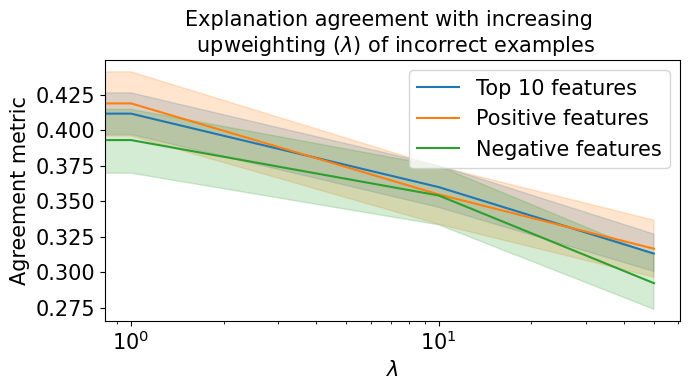

In [16]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.lineplot(data=plot_df, x="const", y="value", hue="variable", errorbar="ci", ax=ax)
ax.set_xscale("log")
plt.legend(fontsize=15)
plt.xlabel("$\lambda$", fontsize=15)
plt.ylabel("Agreement metric", fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title(
    "Explanation agreement with increasing \n upweighting ($\lambda$) of incorrect examples"
    , fontsize=15
)
plt.tight_layout()
plt.savefig(f"img/{dataset_str}_reweight_exp.pdf")

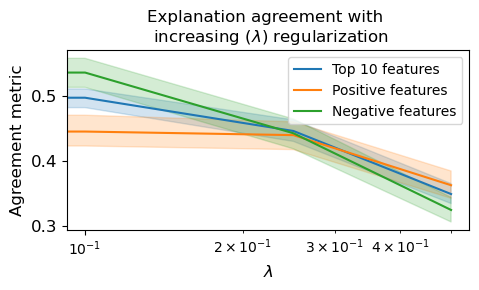

In [13]:
dataset_str = "reviews"
df = pd.read_csv(f"results/{dataset_str}_reg_exp_agree.csv")

plot_df = pd.melt(df[["const", "top_feat", "pos_pred", "neg_pred"]], ["const"])
plot_dict = {
    "top_feat": "Top 10 features",
    "pos_pred": "Positive features",
    "neg_pred": "Negative features",
}
plot_df["variable"] = plot_df["variable"].map(plot_dict)

# fig, ax = plt.subplots(figsize=(7, 4))
# sns.lineplot(data=plot_df, x="const", y="value", hue="variable", errorbar="ci", ax=ax)
# ax.set_xscale("log")
# plt.legend(fontsize=15)
# plt.xlabel("$\lambda$", fontsize=15)
# plt.ylabel("Agreement metric", fontsize=15)
# ax.tick_params(axis='x', labelsize=15)
# ax.tick_params(axis='y', labelsize=15)
# plt.title("Explanation agreement with \n increasing ($\lambda$)  regularization", fontsize=15)
# plt.tight_layout()
# plt.savefig(f"img/{dataset_str}_reg_exp.pdf")

fig, ax = plt.subplots(figsize=(5, 3))
sns.lineplot(data=plot_df, x="const", y="value", hue="variable", errorbar="ci", ax=ax)
ax.set_xscale("log")

# Set legend font size
plt.legend(fontsize=10)

# Set axis labels and title with specific font sizes
ax.set_xlabel("$\lambda$", fontsize=12)
ax.set_ylabel("Agreement metric", fontsize=12)
ax.set_title("Explanation agreement with \n increasing ($\lambda$) regularization", fontsize=12)

# Set tick font sizes for both axes directly through the Axes object
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig(f"img/{dataset_str}_reg_exp.pdf")